In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


**Read in csv file**

In [2]:
df = pd.DataFrame()
def add_taxi_data(colour, *columns):
    '''Adds taxi data to DataFrame df, takes colour as input (green/yellow) and columns as additional arguments.'''
    if colour in ['green', 'yellow']:
        global df
        for year in range(2022, 2025):
            for month in range(1, 13):
                month = str(month).zfill(2)
                file_name = f'Taxi/{colour}_tripdata_{year}-{month}.parquet'

                if os.path.exists(file_name):
                    data = pd.read_parquet(file_name, columns=list(columns))
                    df = pd.concat([df, data], ignore_index=True)
                    print(f'{year}-{month} {colour} Taxi trip data added.')
                else:
                    print(f'File {file_name} not found. Skipping...')
                    
        print(f'{colour} Taxis added to DataFrame')
        return
    else:
        print(f'{colour} not found. Enter "green" or "yellow"')
        return

In [3]:
add_taxi_data('green', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'passenger_count')
add_taxi_data('yellow', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'passenger_count')

df.to_csv('taxi_data_initial.csv', index=False)

2022-01 green Taxi trip data added.
2022-02 green Taxi trip data added.
2022-03 green Taxi trip data added.
2022-04 green Taxi trip data added.
2022-05 green Taxi trip data added.
2022-06 green Taxi trip data added.
2022-07 green Taxi trip data added.
2022-08 green Taxi trip data added.
2022-09 green Taxi trip data added.
2022-10 green Taxi trip data added.
2022-11 green Taxi trip data added.
2022-12 green Taxi trip data added.
2023-01 green Taxi trip data added.
2023-02 green Taxi trip data added.
2023-03 green Taxi trip data added.
2023-04 green Taxi trip data added.
2023-05 green Taxi trip data added.
2023-06 green Taxi trip data added.
2023-07 green Taxi trip data added.
2023-08 green Taxi trip data added.
2023-09 green Taxi trip data added.
2023-10 green Taxi trip data added.
2023-11 green Taxi trip data added.
2023-12 green Taxi trip data added.
2024-01 green Taxi trip data added.
2024-02 green Taxi trip data added.
2024-03 green Taxi trip data added.
File Taxi/green_tripdata_202

In [4]:
# Combine dropoffs and pickup data
df['pickup_datetime'] = df['lpep_pickup_datetime'].fillna(df['tpep_pickup_datetime'])
df['dropoff_datetime'] = df['lpep_dropoff_datetime'].fillna(df['tpep_dropoff_datetime'])

df.drop(columns=['lpep_pickup_datetime', 'tpep_pickup_datetime', 'lpep_dropoff_datetime', 'tpep_dropoff_datetime'], inplace=True)
df.head()

,PULocationID,DOLocationID,passenger_count,pickup_datetime,dropoff_datetime
0,42,42,1.0,2022-01-01 00:14:21,2022-01-01 00:15:33
1,116,41,1.0,2022-01-01 00:20:55,2022-01-01 00:29:38
2,41,140,1.0,2022-01-01 00:57:02,2022-01-01 01:13:14
3,181,181,1.0,2022-01-01 00:07:42,2022-01-01 00:15:57
4,33,170,1.0,2022-01-01 00:07:50,2022-01-01 00:28:52


**Handling duplicate rows**

In [5]:
# Check for duplicate rows
print('Number of duplicate rows before duplicates dropped:', df.duplicated().sum())

# Duplicate rows dropped as likely data entry errors
df = df.drop_duplicates()

print('Number of duplicate rows after duplicates dropped:', df.duplicated().sum())


Number of duplicate rows before duplicates dropped: 664831
Number of duplicate rows after duplicates dropped: 0


In [6]:
df.to_csv('taxi_data_before_datetime.csv', index=False)

**Separate datetime**

In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

df['day'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

pickup_hours = df['pickup_datetime'].dt.hour
dropoff_hours = df['dropoff_datetime'].dt.hour
pickup_minutes = df['pickup_datetime'].dt.minute
dropoff_minutes = df['dropoff_datetime'].dt.minute

condition = (pickup_hours != dropoff_hours) & (dropoff_minutes > 60 - pickup_minutes)
df['hour'] = pickup_hours
df.loc[condition, 'hour'] = dropoff_hours

df.drop(columns=['pickup_datetime', 'dropoff_datetime'], inplace=True)

df

,PULocationID,DOLocationID,passenger_count,day,month,year,hour
0,42,42,1.0,5,1,2022,0
1,116,41,1.0,5,1,2022,0
2,41,140,1.0,5,1,2022,1
3,181,181,1.0,5,1,2022,0
4,33,170,1.0,5,1,2022,0
...,...,...,...,...,...,...,...
89316144,130,218,NaN,6,3,2024,23
89316145,79,100,NaN,6,3,2024,23
89316146,63,181,NaN,6,3,2024,23
89316147,161,148,NaN,6,3,2024,23


In [8]:
df.to_csv('taxi_data_after_datetime.csv', index=False)

**Convert categorical/continuous**

In [9]:
categorical_features = ['PULocationID', 'DOLocationID', 'day', 'month', 'year', 'hour']
df[categorical_features] = df[categorical_features].astype('category')

continuous_features = ['passenger_count']
df[continuous_features] = df[continuous_features].fillna(0)

df[continuous_features] = df[continuous_features].astype('int32')

df.dtypes

PULocationID       category
DOLocationID       category
passenger_count       int32
day                category
month              category
year               category
hour               category
dtype: object

**Check empty values**

In [10]:
df.isna().sum()

PULocationID       0
DOLocationID       0
passenger_count    0
day                0
month              0
year               0
hour               0
dtype: int64

**Ensure values are correct**

In [11]:
for col in df:
    unique_values = df[col].unique().tolist()
    unique_values.sort()  # Sort the unique values
    print(f'{col} Unique Values: {unique_values}\n')

PULocationID Unique Values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

**Data before 2022 must be excluded**

In [12]:
df['year'] = df['year'].astype('int32')

df = df[df['year'] > 2021]

df['year'] = df['year'].astype('category')

df['year'].unique().tolist()

/var/folders/8v/myv9ql5d1lg4ct7vbb0zh8000000gn/T/ipykernel_15339/3268048455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype('category')


[2022, 2023, 2024]

**Remove rows with passenger count = 0**

In [13]:
df = df[df['passenger_count'] > 0]

df['passenger_count'].unique().tolist()

[1, 4, 5, 2, 3, 6, 7, 8, 9]

**Include the Borough**

In [14]:
df_zone = pd.read_csv('taxi_zone_lookup.csv', usecols = ['LocationID', 'Borough'])

**Merge the borough onto the pickup location and dropoff location**

In [15]:
# Merge pickup borough
df = pd.merge(df, df_zone, left_on='PULocationID', right_on='LocationID', how='left')
df = df.rename(columns={'Borough': 'Pickup_Borough'})
df = df.drop(columns=['LocationID'])

# Merge dropoff borough
df = pd.merge(df, df_zone, left_on='DOLocationID', right_on='LocationID', how='left')
df = df.rename(columns={'Borough': 'Dropoff_Borough'})
df = df.drop(columns=['LocationID'])

df.head()

,PULocationID,DOLocationID,passenger_count,day,month,year,hour,Pickup_Borough,Dropoff_Borough
0,42,42,1,5,1,2022,0,Manhattan,Manhattan
1,116,41,1,5,1,2022,0,Manhattan,Manhattan
2,41,140,1,5,1,2022,1,Manhattan,Manhattan
3,181,181,1,5,1,2022,0,Brooklyn,Brooklyn
4,33,170,1,5,1,2022,0,Brooklyn,Manhattan


**Filter to only include journeys to/from Manhattan**

In [16]:
df = df[(df['Pickup_Borough'] == 'Manhattan') | (df['Dropoff_Borough'] == 'Manhattan')]

# Remove the locationID if not in Manhattan
df.loc[df['Dropoff_Borough'] != 'Manhattan', 'DOLocationID'] = np.nan
df.loc[df['Pickup_Borough'] != 'Manhattan', 'PULocationID'] = np.nan
    
df = df.drop(columns=['Pickup_Borough', 'Dropoff_Borough'])

df.isna().sum()

PULocationID       4965877
DOLocationID       4971915
passenger_count          0
day                      0
month                    0
year                     0
hour                     0
dtype: int64

In [17]:
df.isna().sum()

PULocationID       4965877
DOLocationID       4971915
passenger_count          0
day                      0
month                    0
year                     0
hour                     0
dtype: int64

In [18]:
df.head()

,PULocationID,DOLocationID,passenger_count,day,month,year,hour
0,42.0,42.0,1,5,1,2022,0
1,116.0,41.0,1,5,1,2022,0
2,41.0,140.0,1,5,1,2022,1
4,NaN,170.0,1,5,1,2022,0
9,NaN,186.0,1,5,1,2022,0


In [19]:
df.to_csv('taxi_data_borough.csv', index=False)

In [3]:
df = pd.read_csv('taxi_data_borough.csv')

**Sum passenger_count based on rest of features**

In [4]:
grouped_df = df.groupby(['PULocationID', 'DOLocationID', 'day', 'month', 'year', 'hour'], dropna=False)['passenger_count'].sum().reset_index()
grouped_df.head()

,PULocationID,DOLocationID,day,month,year,hour,passenger_count
0,4.0,4.0,0,1,2022,0,3
1,4.0,4.0,0,1,2022,2,1
2,4.0,4.0,0,1,2022,9,2
3,4.0,4.0,0,1,2022,15,5
4,4.0,4.0,0,1,2022,16,6


In [5]:
categorical_features = ['PULocationID', 'DOLocationID', 'day', 'month', 'year', 'hour']

for feature in categorical_features:
    counts = grouped_df.groupby(feature)['passenger_count'].sum()
    print(f"Counts for {feature}:")
    print(counts)
    print()

Counts for PULocationID:
PULocationID
4.0       118498
12.0       62495
13.0      669504
24.0      321969
41.0      396757
          ...   
246.0    1899130
249.0    2526305
261.0     644802
262.0    1437325
263.0    2228230
Name: passenger_count, Length: 67, dtype: int64

Counts for DOLocationID:
DOLocationID
4.0       440702
12.0       84382
13.0      906423
24.0      413067
41.0      777579
          ...   
246.0    2177272
249.0    1937323
261.0     582406
262.0    1754857
263.0    2419619
Name: passenger_count, Length: 67, dtype: int64

Counts for day:
day
0    13610157
1    15452840
2    16287620
3    16866088
4    16833165
5    17312935
6    14111771
Name: passenger_count, dtype: int64

Counts for month:
month
1     10678994
2     11112451
3     12979208
4      8910504
5      9000055
6      8722274
7      7866358
8      7652027
9      7502486
10     9022645
11     8303481
12     8724093
Name: passenger_count, dtype: int64

Counts for year:
year
2022    51251739
2023    48033890


**Transform data to merge Pickup and Dropoff LocationIDs**

In [6]:
transformed_data = []

for index, row in grouped_df.iterrows():
    pu_row = {
        'LocationID': row['PULocationID'],
        'day': row['day'],
        'month': row['month'],
        'year': row['year'],
        'hour': row['hour'],
        'passenger_count': row['passenger_count']
    }
    
    transformed_data.append(pu_row)
    
    if row['DOLocationID'] != row['PULocationID']:
        do_row = {
            'LocationID': row['DOLocationID'],
            'day': row['day'],
            'month': row['month'],
            'year': row['year'],
            'hour': row['hour'],
            'passenger_count': row['passenger_count']
        }
        
        transformed_data.append(do_row)

transformed_df = pd.DataFrame(transformed_data)

transformed_df.head()

,LocationID,day,month,year,hour,passenger_count
0,4.0,0.0,1.0,2022.0,0.0,3.0
1,4.0,0.0,1.0,2022.0,2.0,1.0
2,4.0,0.0,1.0,2022.0,9.0,2.0
3,4.0,0.0,1.0,2022.0,15.0,5.0
4,4.0,0.0,1.0,2022.0,16.0,6.0


In [7]:
transformed_df.isna().sum()

LocationID         519630
day                     0
month                   0
year                    0
hour                    0
passenger_count         0
dtype: int64

**Drop empty rows as they are journeys within a LocationID. Already extracted from pickup location**

In [8]:
transformed_df = transformed_df.dropna()

In [9]:
categorical_features = ['LocationID', 'day', 'month', 'year', 'hour']

for feature in categorical_features:
    counts = transformed_df.groupby(feature)['passenger_count'].sum()
    print(f"Counts for {feature}:")
    print(counts)
    print()

Counts for LocationID:
LocationID
4.0       555392.0
12.0      146271.0
13.0     1558490.0
24.0      728682.0
41.0     1133530.0
           ...    
246.0    3988520.0
249.0    4384126.0
261.0    1213640.0
262.0    3139993.0
263.0    4534054.0
Name: passenger_count, Length: 67, dtype: float64

Counts for day:
day
0.0    24638967.0
1.0    28318913.0
2.0    29867487.0
3.0    30847447.0
4.0    30758370.0
5.0    31954461.0
6.0    25471483.0
Name: passenger_count, dtype: float64

Counts for month:
month
1.0     19628454.0
2.0     20467810.0
3.0     23754834.0
4.0     16292567.0
5.0     16407460.0
6.0     15917876.0
7.0     14353805.0
8.0     13943335.0
9.0     13633552.0
10.0    16431796.0
11.0    15148771.0
12.0    15876868.0
Name: passenger_count, dtype: float64

Counts for year:
year
2022.0    93705031.0
2023.0    87645967.0
2024.0    20506130.0
Name: passenger_count, dtype: float64

Counts for hour:
hour
0.0      5672808.0
1.0      3889653.0
2.0      2628448.0
3.0      1669153.0
4.0     

In [10]:
print('Number of duplicate rows:', transformed_df.duplicated().sum())

Number of duplicate rows: 12720697


**Recombine data to remove duplicates, can't drop as different journeys**

In [11]:
transformed_df_combined = transformed_df.groupby(['LocationID', 'day', 'month', 'year', 'hour'], dropna=False)['passenger_count'].sum().reset_index()
transformed_df_combined.head()

,LocationID,day,month,year,hour,passenger_count
0,4.0,0.0,1.0,2022.0,0.0,91.0
1,4.0,0.0,1.0,2022.0,1.0,35.0
2,4.0,0.0,1.0,2022.0,2.0,13.0
3,4.0,0.0,1.0,2022.0,3.0,9.0
4,4.0,0.0,1.0,2022.0,4.0,10.0


In [12]:
print('Number of duplicate rows:', transformed_df_combined.duplicated().sum())

Number of duplicate rows: 0


**Integrity Checks**

In [13]:
for feature in categorical_features:
    counts = transformed_df_combined.groupby(feature)['passenger_count'].sum()
    print(f"Counts for {feature}:")
    print(counts)
    print()

Counts for LocationID:
LocationID
4.0       555392.0
12.0      146271.0
13.0     1558490.0
24.0      728682.0
41.0     1133530.0
           ...    
246.0    3988520.0
249.0    4384126.0
261.0    1213640.0
262.0    3139993.0
263.0    4534054.0
Name: passenger_count, Length: 67, dtype: float64

Counts for day:
day
0.0    24638967.0
1.0    28318913.0
2.0    29867487.0
3.0    30847447.0
4.0    30758370.0
5.0    31954461.0
6.0    25471483.0
Name: passenger_count, dtype: float64

Counts for month:
month
1.0     19628454.0
2.0     20467810.0
3.0     23754834.0
4.0     16292567.0
5.0     16407460.0
6.0     15917876.0
7.0     14353805.0
8.0     13943335.0
9.0     13633552.0
10.0    16431796.0
11.0    15148771.0
12.0    15876868.0
Name: passenger_count, dtype: float64

Counts for year:
year
2022.0    93705031.0
2023.0    87645967.0
2024.0    20506130.0
Name: passenger_count, dtype: float64

Counts for hour:
hour
0.0      5672808.0
1.0      3889653.0
2.0      2628448.0
3.0      1669153.0
4.0     

In [14]:
for col in transformed_df_combined:
    unique_values = transformed_df_combined[col].unique().tolist()
    unique_values.sort()
    print(f'{col} Unique Values: {unique_values}\n')

LocationID Unique Values: [4.0, 12.0, 13.0, 24.0, 41.0, 42.0, 43.0, 45.0, 48.0, 50.0, 68.0, 74.0, 75.0, 79.0, 87.0, 88.0, 90.0, 100.0, 105.0, 107.0, 113.0, 114.0, 116.0, 120.0, 125.0, 127.0, 128.0, 137.0, 140.0, 141.0, 142.0, 143.0, 144.0, 148.0, 151.0, 152.0, 153.0, 158.0, 161.0, 162.0, 163.0, 164.0, 166.0, 170.0, 186.0, 194.0, 202.0, 209.0, 211.0, 224.0, 229.0, 230.0, 231.0, 232.0, 233.0, 234.0, 236.0, 237.0, 238.0, 239.0, 243.0, 244.0, 246.0, 249.0, 261.0, 262.0, 263.0]

day Unique Values: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

month Unique Values: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

year Unique Values: [2022.0, 2023.0, 2024.0]

hour Unique Values: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]

passenger_count Unique Values: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0

**Reclassify Types**

In [15]:
transformed_df_combined = transformed_df_combined.astype('int32')

In [16]:
categorical_features = ['LocationID', 'day', 'month', 'year', 'hour']
transformed_df_combined[categorical_features] = transformed_df_combined[categorical_features].astype('category')

continuous_features = ['passenger_count']

transformed_df_combined[continuous_features] = transformed_df_combined[continuous_features].astype('int32')

transformed_df_combined.dtypes    

LocationID         category
day                category
month              category
year               category
hour               category
passenger_count       int32
dtype: object

**Should be 0 duplicates**

In [17]:
print('Number of duplicate rows:', transformed_df_combined.duplicated().sum())

Number of duplicate rows: 0


**Should be 0 empty values**

In [18]:
transformed_df_combined.isna().sum()

LocationID         0
day                0
month              0
year               0
hour               0
passenger_count    0
dtype: int64

In [19]:
transformed_df_combined.describe().T

,count,mean,std,min,25%,50%,75%,max
passenger_count,292356.0,690.449753,821.169935,1.0,86.0,358.0,1031.0,6376.0


**Correlation Plots**

In [20]:
for feature in categorical_features:
    counts = transformed_df_combined.groupby(feature, observed=True)['passenger_count'].sum()
    print(f"Counts for {feature}:")
    print(counts)
    print()

Counts for LocationID:
LocationID
4       555392
12      146271
13     1558490
24      728682
41     1133530
        ...   
246    3988520
249    4384126
261    1213640
262    3139993
263    4534054
Name: passenger_count, Length: 67, dtype: int32

Counts for day:
day
0    24638967
1    28318913
2    29867487
3    30847447
4    30758370
5    31954461
6    25471483
Name: passenger_count, dtype: int32

Counts for month:
month
1     19628454
2     20467810
3     23754834
4     16292567
5     16407460
6     15917876
7     14353805
8     13943335
9     13633552
10    16431796
11    15148771
12    15876868
Name: passenger_count, dtype: int32

Counts for year:
year
2022    93705031
2023    87645967
2024    20506130
Name: passenger_count, dtype: int32

Counts for hour:
hour
0      5672808
1      3889653
2      2628448
3      1669153
4       967712
5       844133
6      2203320
7      4776136
8      6993980
9      8255525
10     9314361
11    10247328
12    11229640
13    11483744
14    12174614

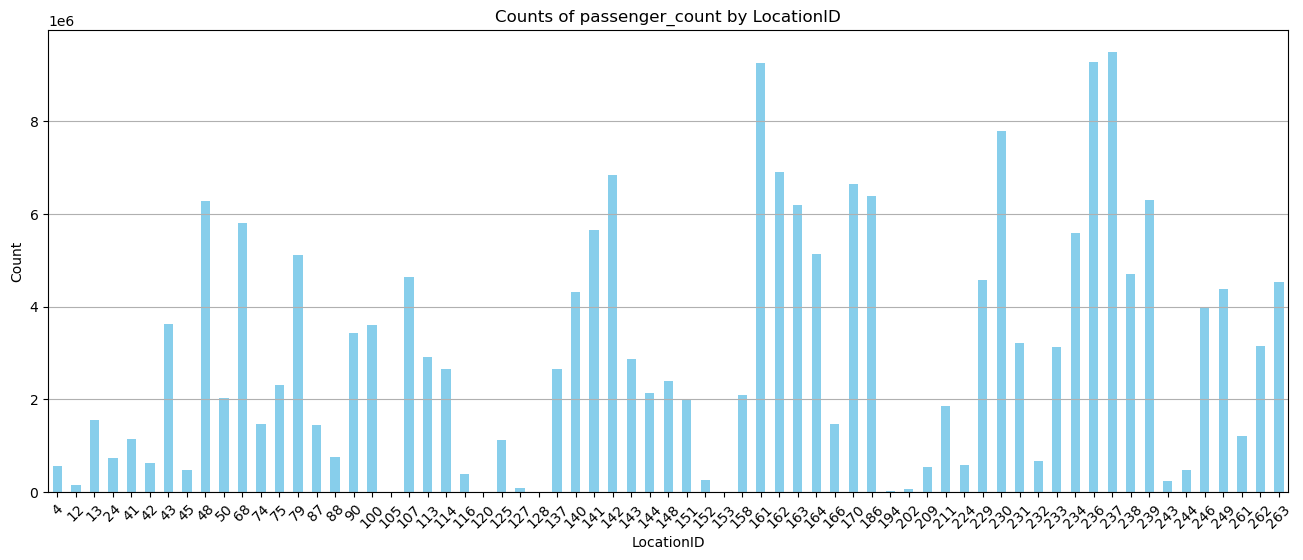

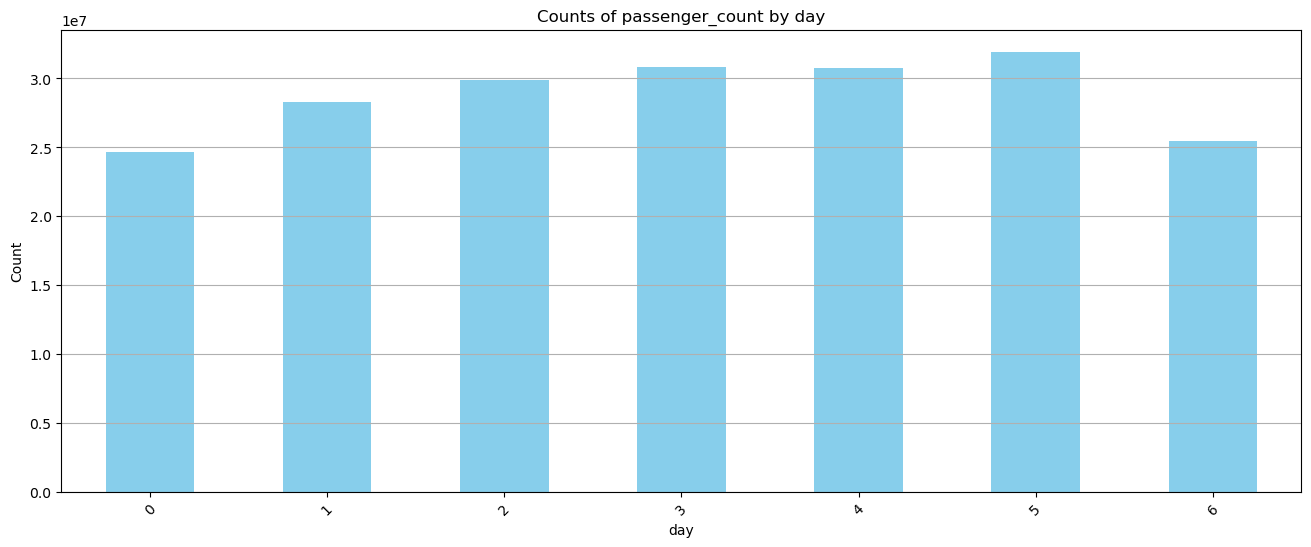

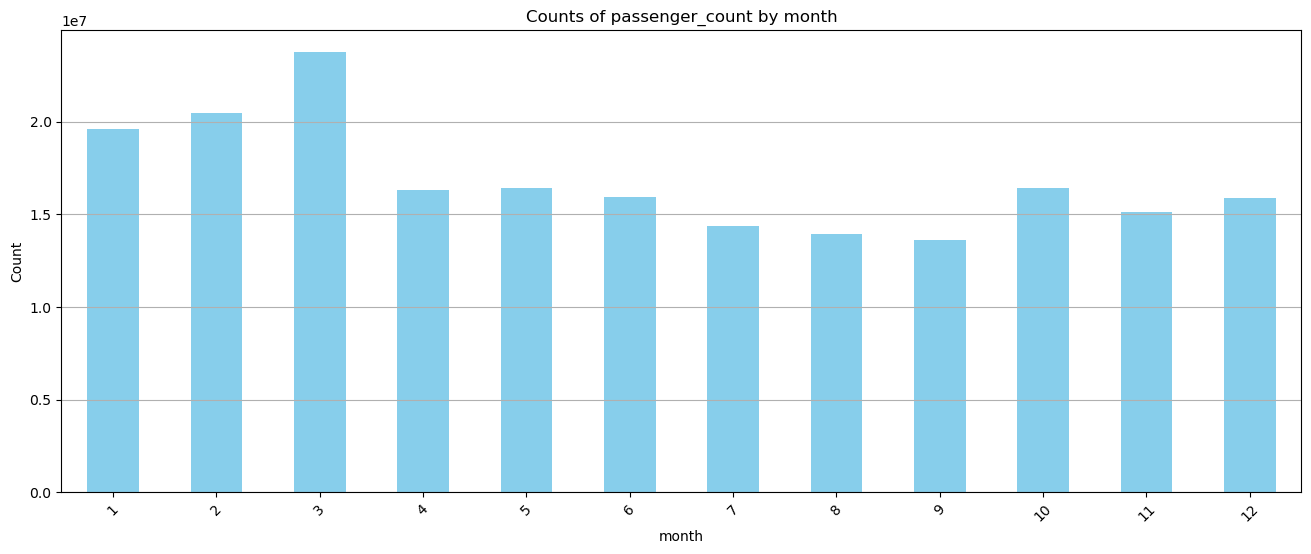

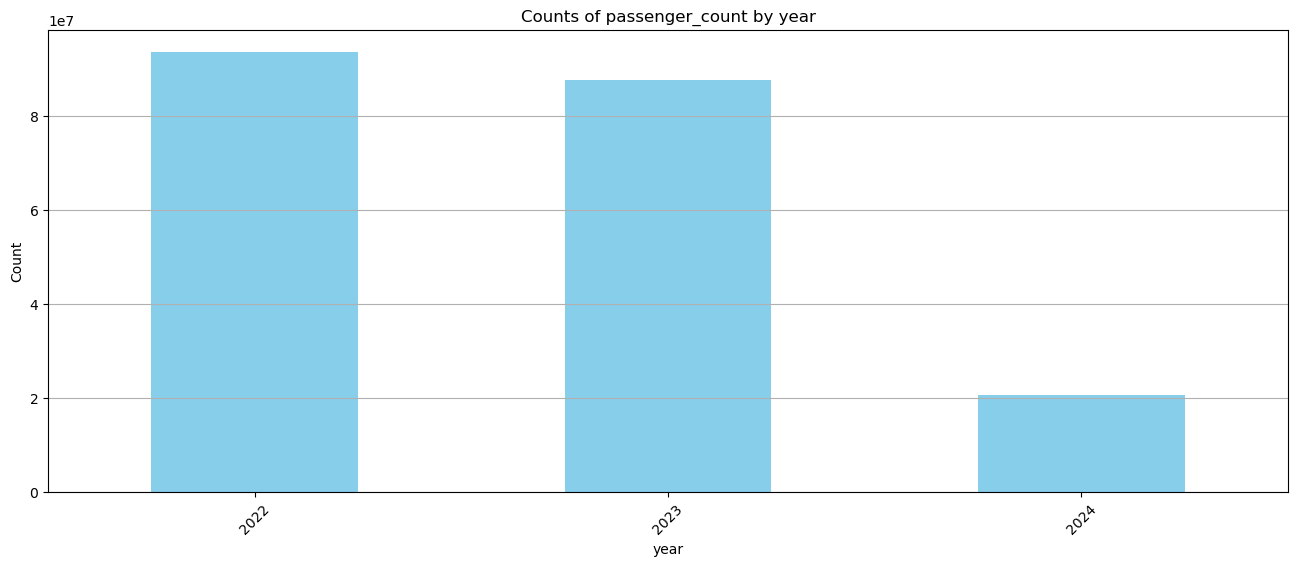

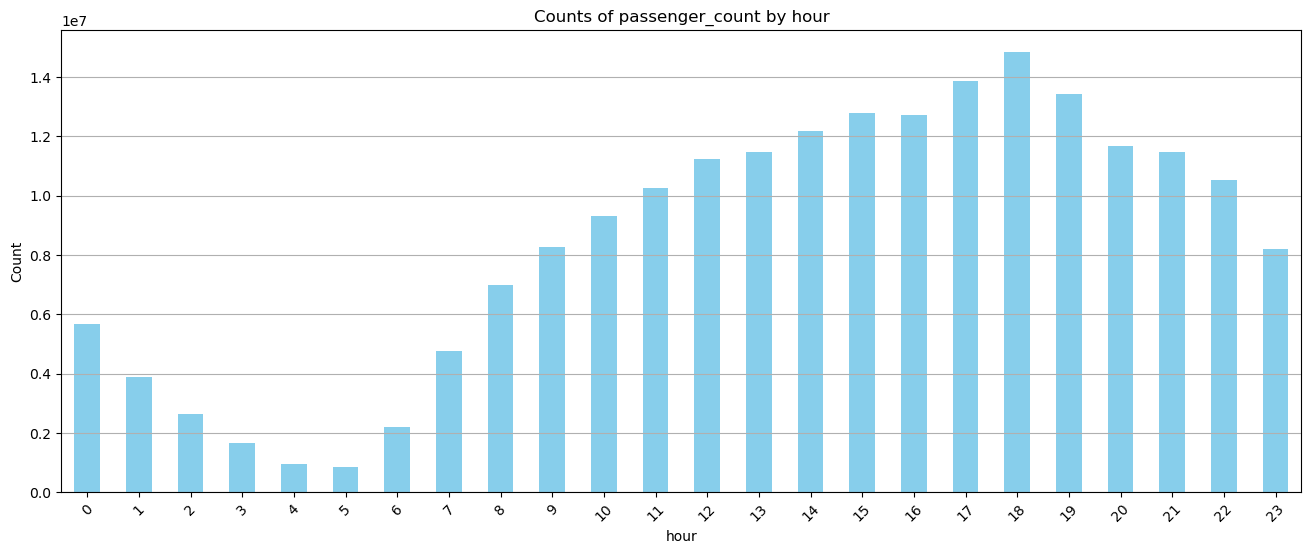

In [21]:
for feature in categorical_features:
    plt.figure(figsize=(16, 6))
    counts = transformed_df_combined.groupby(feature, observed=True)['passenger_count'].sum()
    counts.plot(kind='bar', color='skyblue')
    plt.title(f'Counts of passenger_count by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

In [22]:
transformed_df_combined.to_csv('taxi_data_grouped.csv', index=False)

In [23]:
transformed_df_combined.head(50)

,LocationID,day,month,year,hour,passenger_count
0,4,0,1,2022,0,91
1,4,0,1,2022,1,35
2,4,0,1,2022,2,13
3,4,0,1,2022,3,9
4,4,0,1,2022,4,10
5,4,0,1,2022,5,11
6,4,0,1,2022,6,6
7,4,0,1,2022,7,38
8,4,0,1,2022,8,76
9,4,0,1,2022,9,51


**Add Busyness Rank**

In [26]:
mean = transformed_df_combined['passenger_count'].mean()
std = transformed_df_combined['passenger_count'].std()

print(f'Mean: {mean} \nStandard Deviation: {std}')

Mean: 690.4497530408132 
Standard Deviation: 821.1699353574098


In [32]:
Q1 = transformed_df_combined['passenger_count'].quantile(0.20)
Q2 = transformed_df_combined['passenger_count'].quantile(0.40)
Q3 = transformed_df_combined['passenger_count'].quantile(0.60)
Q4 = transformed_df_combined['passenger_count'].quantile(0.80)
Q5 = transformed_df_combined['passenger_count'].max()  # Use max for the upper bound

# Define bins ensuring no duplicates
bins = [-np.inf, Q1, Q2, Q3, Q4, Q5]  # Adjust bins to ensure they are unique
labels = [5, 4, 3, 2, 1]  # Five labels for five bins

# Ensure all bins have at least one entry
transformed_df_combined['busyness_rank'] = pd.cut(transformed_df_combined['passenger_count'], bins=bins, labels=labels)

In [34]:
transformed_df_combined['busyness_rank'] = transformed_df_combined['busyness_rank'].astype(int)

In [35]:
transformed_df_combined.head(50)

,LocationID,day,month,year,hour,passenger_count,busyness_rank
0,4,0,1,2022,0,91.0,4
1,4,0,1,2022,1,35.0,5
2,4,0,1,2022,2,13.0,5
3,4,0,1,2022,3,9.0,5
4,4,0,1,2022,4,10.0,5
5,4,0,1,2022,5,11.0,5
6,4,0,1,2022,6,6.0,5
7,4,0,1,2022,7,38.0,5
8,4,0,1,2022,8,76.0,4
9,4,0,1,2022,9,51.0,5


In [36]:
df = transformed_df_combined

**Plot average busyness rank per location**

/var/folders/8v/myv9ql5d1lg4ct7vbb0zh8000000gn/T/ipykernel_45488/156313315.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_busyness_per_location = df.groupby('LocationID')['busyness_rank'].mean().reset_index()


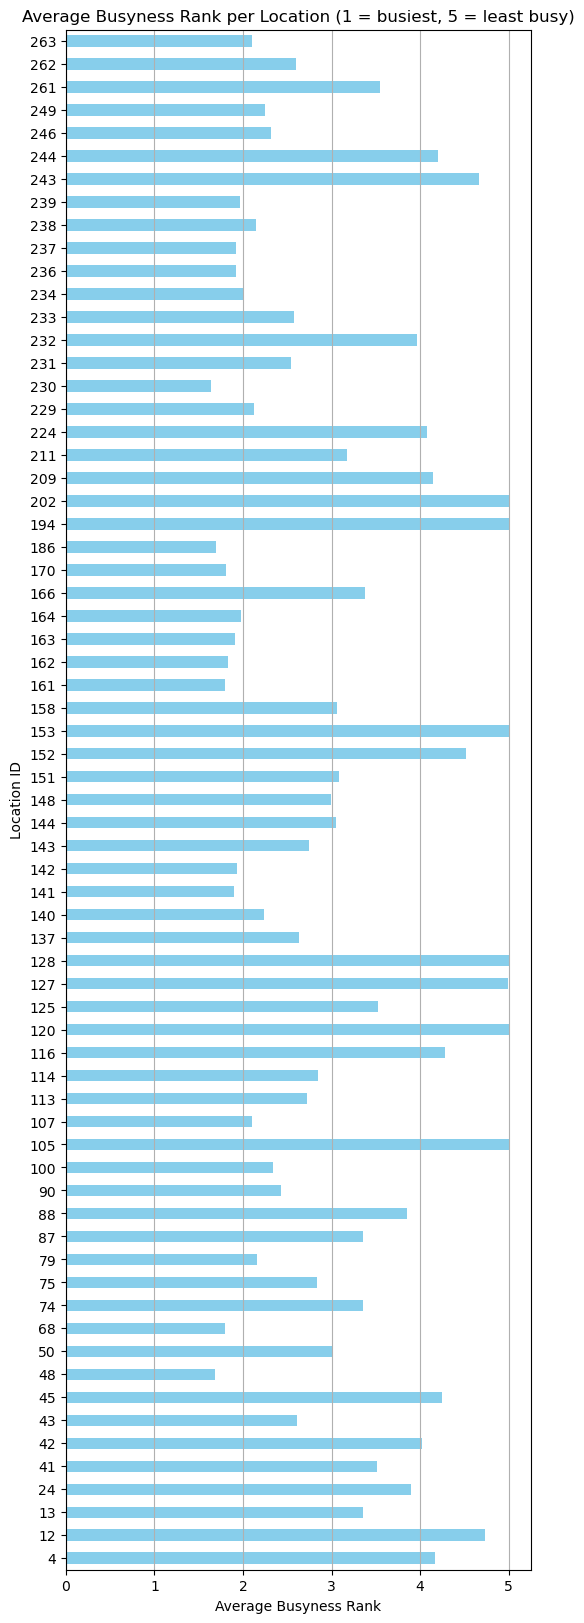

In [37]:
average_busyness_per_location = df.groupby('LocationID')['busyness_rank'].mean().reset_index()
plt.figure(figsize=(6, 20))
average = average_busyness_per_location.set_index('LocationID')['busyness_rank']
average.plot(kind='barh', color='skyblue')
plt.title('Average Busyness Rank per Location (1 = busiest, 5 = least busy)')
plt.xlabel('Average Busyness Rank')
plt.ylabel('Location ID')
plt.grid(axis='x')
plt.show()

In [38]:
df.to_csv('taxi_data_final.csv', index=False)